# Estimating Vol

## 4. GARCH

In [7]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize, Bounds, LinearConstraint

import yfinance as yf
from arch import arch_model
import scipy

In [8]:
# GARCH(1, 1) 모델 클래스
class garchOneOne:

    # 초기화 함수
    def __init__(self, rets):

        # 수익률 # 자연수(아치모델에서는 자연수로)
        self.rets = rets * 100

        # 분산 ; 모델(가치 필터)을 통과해서 새롭게 나올 분산값
        self.sigma_2 = self.garch_filter(self.garch_optimization())

        # GARCH 모델 계수
        self.coefficients = self.garch_optimization()

    # GARCH 모델에 기반한 변동성 추정치 산출 함수
    def garch_filter(self, parameters):

        # 패러미터 값
        alpha = parameters[0] # 변동성의 장기 균형점
        beta = parameters[1] # 이전 기수 수익률의 평균 회귀 속도
        delta = parameters[2] # 이전 기수 변동성의 평균 회귀 속도 

        # 수익률 데이터의 길이
        length = len(self.rets) 

        # 빈 배열 초기화하기 ; 분산값을 계산해서 계속 집어 넣을 
        sigma_2 = np.zeros(length)

        # 배열 채우기, 만약 i가 0이라면 장기분산값을 사용
        for i in range(length):
            if i == 0: # i 가 0이면 계산 못하니, 그 경우 장기 분산값
                sigma_2[i] = alpha / (1 - beta - delta)
            else: # 수식 그대로  : 변동성의 장기 균형점(alpha) + 평균회귀속도(beta)*이전기수 수익율의 제곱 + 평균회귀속도(delta)*이전기수 변동성 (얜 이미 제곱)
                sigma_2[i] = alpha + beta * self.rets[i-1] ** 2 + delta * sigma_2[i-1]

        # 분산 값 반환
        return sigma_2 # 파라미터를 받아서 실제 변동성 필터를 계산하는 함수이다. 

    # GARCH 모델의 로그우도함수; 최적화 수행 전에, 최우도 추정법 사용시 로그 우도 함수가 필요함. 
    def garch_loglikelihood(self, parameters):

        # 데이터 길이
        length = len(self.rets)

        # 분산 값
        sigma_2 = self.garch_filter(parameters)

        # 로그우도
        loglikelihood = -np.sum(-np.log(sigma_2) - self.rets ** 2 / sigma_2)

        # 로그우도 값 반환
        return loglikelihood

    # GARCH 모델 최적화
    def garch_optimization(self):

        # 패러미터값 초기화; 개인 선택; 어짜피 바뀔거임
        parameters = [0.1, 0.05, 0.92]
        
        # 패러미터 최적화
        # scipy 패키지에는 maximize 함수가 존재하지 않으므로,
        # 로그우도함수에 마이너스 값을 부텨 minimize 함수를 대신 사용
        opt = scipy.optimize.minimize(self.garch_loglikelihood,
                                      parameters,
                                      bounds=((0.001, 1), (0.001, 1), (0.001, 1)))

        # 분산값
        variance = 0.01 ** 2 + opt.x[0] / (1 - opt.x[1] - opt.x[2])

        # 추정한 패러미터값과 분산값을 반환
        return np.append(opt.x, variance)

### GARCH 모델로 VIX 추정

In [9]:
# 가격 데이터 다운로드
SPX = yf.download('^GSPC', start='2005-01-01', interval='1d')
VIX = yf.download('^VIX', start='2005-01-01', interval='1d')

# 수익률 계산
ret = SPX['Adj Close'].pct_change().dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [10]:
ret

Date
2005-01-04   -0.011671
2005-01-05   -0.003628
2005-01-06    0.003506
2005-01-07   -0.001431
2005-01-10    0.003423
                ...   
2024-08-28   -0.005976
2024-08-29   -0.000039
2024-08-30    0.010093
2024-09-03   -0.021151
2024-09-04   -0.000658
Name: Adj Close, Length: 4950, dtype: float64

In [11]:
# GARCH 모델 최적화 수행
modelSPX = garchOneOne(ret)

/var/folders/h1/6sllxx6j0zb6l_hvj_9ys3qh0000gn/T/ipykernel_72580/1892034971.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma_2[i] = alpha + beta * self.rets[i-1] ** 2 + delta * sigma_2[i-1]


                    0
Date                 
2005-01-04  16.956310
2005-01-05  17.158868
2005-01-06  16.183193
2005-01-07  15.291973
2005-01-10  14.376767
...               ...
2024-08-28  14.918497
2024-08-29  14.407288
2024-08-30  13.550476
2024-09-03  13.963293
2024-09-04  17.679744

[4950 rows x 1 columns]


Text(0.5, 1.0, 'GARCH(1, 1) process and VIX')

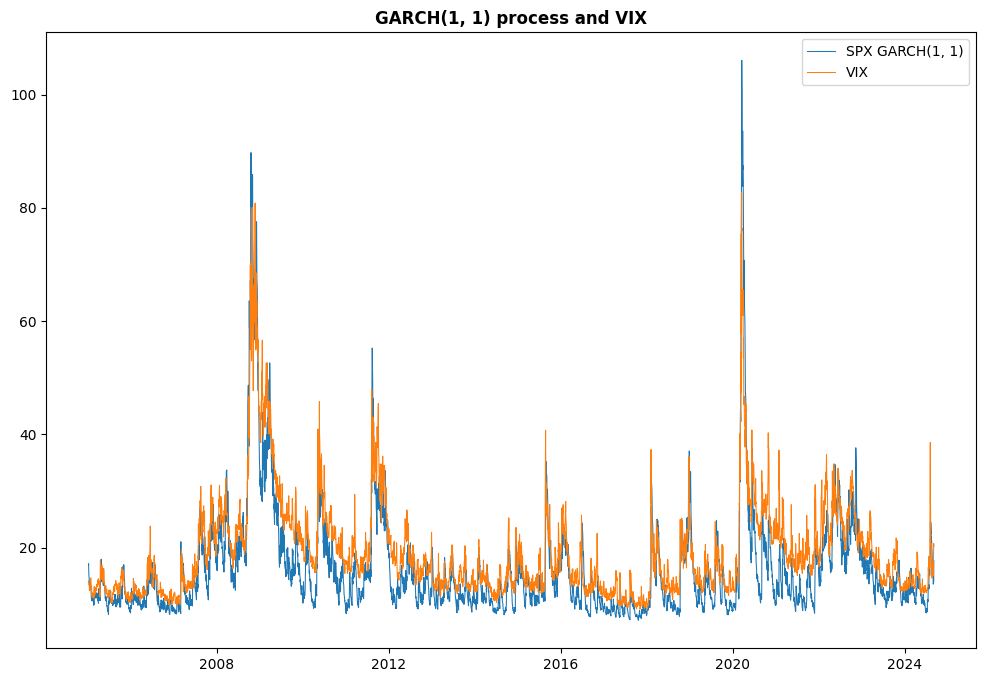

In [13]:
# 결과값을 데이터프레임으로 변환하고 연율화
res = pd.DataFrame(np.sqrt(modelSPX.sigma_2 * 252), index=SPX.index[1:])
print(res)
# 그래프 시각화
plt.figure(figsize=(12, 8))
plt.plot(res, label='SPX GARCH(1, 1)', linewidth=0.75)
plt.plot(VIX.Close, label='VIX', linewidth=0.75)
plt.legend()
plt.title('GARCH(1, 1) process and VIX', fontweight='bold')

### arch package GARCH 

In [14]:
# arch 패키지에서 arch_model 임포트
from arch import arch_model

# arch_model을 활용해 GARCH 모델 최적화 수행
arch_mSPX = arch_model(ret * 100, mean='Zero', vol='GARCH') # 장기평균 0
arch_mSPX = arch_mSPX.fit()

# 신뢰구간 추정
conf_int_SPX = pd.DataFrame(arch_mSPX.conf_int(alpha=0.2))

# 테스트 수행
conf_int_SPX['garchOneOne'] = modelSPX.coefficients[:-1] #마지막 분산 값 빼고, 앞에 3개 가 페러미터 값
conf_int_SPX['Test'] = np.where(conf_int_SPX['garchOneOne'] < conf_int_SPX['upper'], np.where(conf_int_SPX['garchOneOne'] > conf_int_SPX['lower'], 'OK', 'Not OK'), 'Not OK')

# loglikelihood 가 최소값 될때까지 10번 돌았고
# 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 2760820574.7413692
Iteration:      2,   Func. Count:     11,   Neg. LLF: 9228.296383094721
Iteration:      3,   Func. Count:     17,   Neg. LLF: 6743.322215875725
Iteration:      4,   Func. Count:     22,   Neg. LLF: 6620.718276429618
Iteration:      5,   Func. Count:     27,   Neg. LLF: 6797.710696926316
Iteration:      6,   Func. Count:     32,   Neg. LLF: 6605.605494463935
Iteration:      7,   Func. Count:     36,   Neg. LLF: 6605.5940914423045
Iteration:      8,   Func. Count:     40,   Neg. LLF: 6605.593990738345
Iteration:      9,   Func. Count:     44,   Neg. LLF: 6605.593986654504
Iteration:     10,   Func. Count:     47,   Neg. LLF: 6605.593986651847
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6605.593986654504
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


In [15]:
# 테스트 결과
conf_int_SPX

,lower,upper,garchOneOne,Test
omega,0.018286,0.031524,0.025249,OK
alpha[1],0.107866,0.141705,0.123930,OK
beta[1],0.836760,0.872326,0.853940,OK
